The project will be looking at forcasting crimes based upon weather data.  The data used is from Minneapolis, MN from 2015, 2016, and 2017.  The weather data is from the Minneapolis-St. Paul International Airport for the same years.

## Importing Modules

In [179]:
from IPython.display import Image                   # image display
import matplotlib.pyplot as plt                     # visualization
import numpy as np                                  # random number generation
import pandas as pd                                 # dataframes

# inline display of plots
%matplotlib inline

from sklearn.cluster import KMeans                        # k-means clustering 
from sklearn.model_selection import train_test_split      # train/test data
from sklearn.neighbors import KNeighborsClassifier        # k-NN classification 
from sklearn.linear_model import LogisticRegression       # logistic regression 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report

## Loading the Datasets into Pandas Dataframes

In [78]:
pd15 = pd.read_csv("data/Police_Incidents_2015.csv", parse_dates=['BeginDate'], header=0)
pd16 = pd.read_csv("data/Police_Incidents_2016.csv", parse_dates=['BeginDate'], header=0)
pd17 = pd.read_csv("data/Police_Incidents_2017.csv", parse_dates=['BeginDate'], header=0)
wx = pd.read_csv("data/MSP_weather.csv", parse_dates=['DATE'], index_col=5, header=0)

#pd15 = pd.read_csv("data/Police_Incidents_2015.csv", parse_dates=['BeginDate'], header=0, usecols=['BeginDate', 'Time', 'Offense', 'Description', 'Neighborhood'])
#pd16 = pd.read_csv("data/Police_Incidents_2016.csv", parse_dates=['BeginDate'], header=0, usecols=['BeginDate', 'Time', 'Offense', 'Description', 'Neighborhood'])
#pd17 = pd.read_csv("data/Police_Incidents_2017.csv", parse_dates=['BeginDate'], header=0, usecols=['BeginDate', 'Time', 'Offense', 'Description', 'Neighborhood'])
#wx = pd.read_csv("data/MSP_weather.csv", index_col=0, parse_dates=True, header=0, usecols=['DATE', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WT09'])

## Combine the Police Incident Dataframes into One Dataframe

In [79]:
# Append police dataframes
pd_df = pd15.append(pd16, sort=False, ignore_index=True)  # ignores the existing row indices and creates new default indices
pd_df = pd_df.append(pd17, sort=False, ignore_index=True)

## Explore the Police and Weather Dataframes

In [81]:
pd_df.shape

(62238, 20)

In [28]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62238 entries, 0 to 62237
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   FID             62238 non-null  int64         
 1   PublicAddress   62238 non-null  object        
 2   ControlNbr      62238 non-null  int64         
 3   CCN             62238 non-null  object        
 4   Precinct        62199 non-null  float64       
 5   ReportedDate    62238 non-null  object        
 6   BeginDate       62238 non-null  datetime64[ns]
 7   Time            62238 non-null  object        
 8   Offense         62238 non-null  object        
 9   Description     62238 non-null  object        
 10  UCRCode         62238 non-null  int64         
 11  EnteredDate     62238 non-null  object        
 12  GBSID           54717 non-null  float64       
 13  Lat             62238 non-null  float64       
 14  Long            62238 non-null  float64       
 15  X 

In [82]:
wx.shape

(1096, 45)

In [84]:
wx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2015-01-01 to 2017-12-31
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          1096 non-null   object 
 1   NAME             1096 non-null   object 
 2   LATITUDE         1096 non-null   float64
 3   LONGITUDE        1096 non-null   float64
 4   ELEVATION        1096 non-null   float64
 5   AWND             1096 non-null   float64
 6   AWND_ATTRIBUTES  1096 non-null   object 
 7   PGTM             2 non-null      float64
 8   PGTM_ATTRIBUTES  2 non-null      object 
 9   PRCP             1096 non-null   float64
 10  PRCP_ATTRIBUTES  1096 non-null   object 
 11  SNOW             1096 non-null   float64
 12  SNOW_ATTRIBUTES  1096 non-null   object 
 13  SNWD             1096 non-null   float64
 14  SNWD_ATTRIBUTES  1096 non-null   object 
 15  TAVG             1096 non-null   int64  
 16  TAVG_ATTRIBUTES  1096 non-null   object 
 

## Join the Police and Weather Dataframes

In [85]:
# Strip date out of BeginDate column of police dataframe.
pd_df['BeginDate'] = pd.to_datetime(pd_df['BeginDate']).dt.normalize()

# Set BeginDate column as the index.
pd_df = pd_df.set_index('BeginDate')                                       

# Join the crime and weather dataframes using the intersection of the date indices.
combined_df = pd_df.join(wx, how='inner')

## Explore the Combined Dataframe

In [86]:
combined_df.shape

(61962, 64)

In [87]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61962 entries, 2015-01-01 to 2017-12-31
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FID              61962 non-null  int64  
 1   PublicAddress    61962 non-null  object 
 2   ControlNbr       61962 non-null  int64  
 3   CCN              61962 non-null  object 
 4   Precinct         61923 non-null  float64
 5   ReportedDate     61962 non-null  object 
 6   Time             61962 non-null  object 
 7   Offense          61962 non-null  object 
 8   Description      61962 non-null  object 
 9   UCRCode          61962 non-null  int64  
 10  EnteredDate      61962 non-null  object 
 11  GBSID            54464 non-null  float64
 12  Lat              61962 non-null  float64
 13  Long             61962 non-null  float64
 14  X                61962 non-null  float64
 15  Y                61962 non-null  float64
 16  Neighborhood     61724 non-null  object 


## Filtering Out Unnecessary Data

In [88]:
combined_df = combined_df[['Time', 'Offense', 'Description', 'Neighborhood', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WT09']]

In [89]:
# Reset the index.
combined_df.reset_index(inplace=True)

# Rename column named index to Date.
combined_df.rename(columns = {'index':'Date'}, inplace = True) 

In [91]:
combined_df.shape

(61962, 13)

In [90]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61962 entries, 0 to 61961
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          61962 non-null  datetime64[ns]
 1   Time          61962 non-null  object        
 2   Offense       61962 non-null  object        
 3   Description   61962 non-null  object        
 4   Neighborhood  61724 non-null  object        
 5   AWND          61962 non-null  float64       
 6   PRCP          61962 non-null  float64       
 7   SNOW          61962 non-null  float64       
 8   SNWD          61962 non-null  float64       
 9   TAVG          61962 non-null  int64         
 10  TMAX          61962 non-null  int64         
 11  TMIN          61962 non-null  int64         
 12  WT09          510 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 6.1+ MB


## Handle Missing Values

In [61]:
combined_df.isna().sum()

Date                0
Time                0
Offense             0
Description         0
Neighborhood      238
AWND                0
PRCP                0
SNOW                0
SNWD                0
TAVG                0
TMAX                0
TMIN                0
WT09            61452
dtype: int64

In [ ]:
# Need to add code here

## Add Rain, Month and BusDay Columns

In [99]:
# Add Rain column to indicate it rained on that day.
combined_df['Rain'] = np.where((combined_df.PRCP > 0) & (combined_df.SNOW == 0), 1, 0)

# Add Month column with abbreviated month name.
months = ("Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")

combined_df['Month'] = pd.Categorical([months[(combined_df.Date[i].month)-1] for i in range(len(combined_df))])

# Add BusDay column to indicate if the Date is a business day or not.
combined_df['BusDay'] = np.is_busday(combined_df.Date.dt.date) 

In [100]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61962 entries, 0 to 61961
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          61962 non-null  datetime64[ns]
 1   Time          61962 non-null  object        
 2   Offense       61962 non-null  object        
 3   Description   61962 non-null  object        
 4   Neighborhood  61724 non-null  object        
 5   AWND          61962 non-null  float64       
 6   PRCP          61962 non-null  float64       
 7   SNOW          61962 non-null  float64       
 8   SNWD          61962 non-null  float64       
 9   TAVG          61962 non-null  int64         
 10  TMAX          61962 non-null  int64         
 11  TMIN          61962 non-null  int64         
 12  WT09          510 non-null    float64       
 13  Rain          61962 non-null  int32         
 14  Month         61962 non-null  category      
 15  BusDay        61962 non-null  bool  

## Converting Categorical Columns into Numeric Columns

In [101]:
combined_df.BusDay = pd.Categorical(combined_df.BusDay)   # Step 1: declare the column is categorical 
combined_df.BusDay = combined_df.BusDay.cat.codes         # Step 2: convert each category to its corresponding code

In [102]:
combined_df.head()

,Date,Time,Offense,Description,Neighborhood,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT09,Rain,Month,BusDay
0,2015-01-01,01:05:00,ASLT2,Asslt W/dngrs Weapon,EAST PHILLIPS,10.51,0.0,0.0,3.1,18,30,11,NaN,0,Jan,1
1,2015-01-01,01:40:00,ROBPER,Robbery Of Person,DOWNTOWN WEST,10.51,0.0,0.0,3.1,18,30,11,NaN,0,Jan,1
2,2015-01-01,01:30:00,THEFT,Other Theft,LOWRY HILL EAST,10.51,0.0,0.0,3.1,18,30,11,NaN,0,Jan,1
3,2015-01-01,02:58:00,ASLT4,Aslt-police/emerg P,DOWNTOWN WEST,10.51,0.0,0.0,3.1,18,30,11,NaN,0,Jan,1
4,2015-01-01,01:45:00,AUTOTH,Motor Vehicle Theft,DOWNTOWN WEST,10.51,0.0,0.0,3.1,18,30,11,NaN,0,Jan,1


## Get Some Counts of the Data

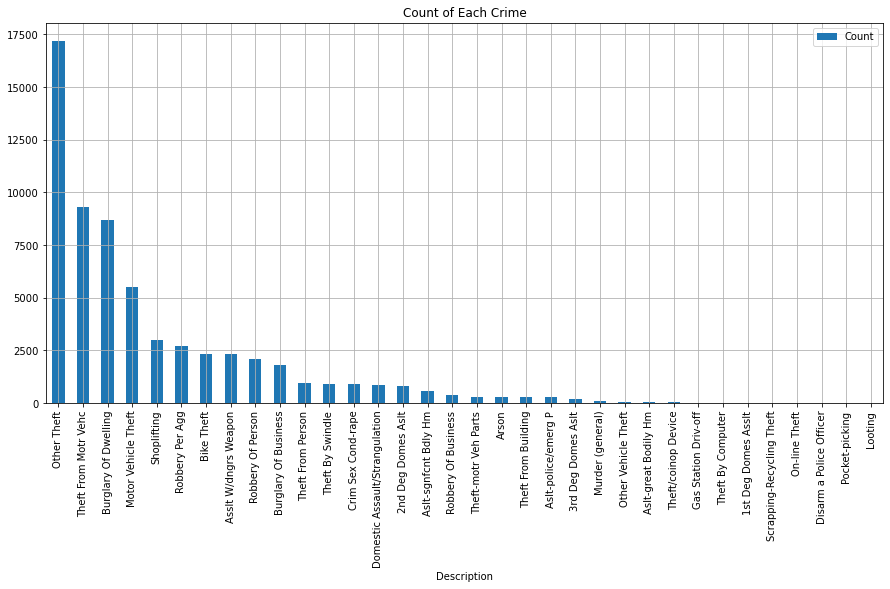

In [104]:
# Get count of each crime.
crime_cnt = pd.DataFrame(combined_df.Description.value_counts())

# Reset the index.
crime_cnt.reset_index(inplace=True)

# Rename columns.
crime_cnt.rename(columns = {'Description':'Count', 'index':'Description'}, inplace = True)       

# Create bar chart of the count of each crime.
crime_cnt.plot(kind="bar",title="Count of Each Crime",x='Description', y='Count', grid=True, figsize=(15,7))
plt.show()

In [106]:
# Get count of each crime per month.
crime_mth = pd.DataFrame(combined_df.groupby(["Description", "Month"])["Offense"].count())
crime_mth

Offense
Description         Month         
1st Deg Domes Asslt Apr          0
                    Aug          1
                    Dec          2
                    Feb          0
                    Jan          1
...                            ...
Theft/coinop Device Mar          2
                    May          1
                    Nov          7
                    Oct          1
                    Sep         11

[408 rows x 1 columns]

In [109]:
# Get count of each crime by neighborhood.
crime_nbh = pd.DataFrame(combined_df.groupby(["Neighborhood", "Description"])["Offense"].count())
crime_nbh

Offense
Neighborhood Description                  
ARMATAGE     2nd Deg Domes Aslt          1
             Arson                       1
             Asslt W/dngrs Weapon        3
             Bike Theft                  1
             Burglary Of Business        6
...                                    ...
WINDOM PARK  Theft By Swindle           20
             Theft From Building         1
             Theft From Motr Vehc       59
             Theft From Person           6
             Theft-motr Veh Parts        3

[1854 rows x 1 columns]

In [141]:
# Get avg. Precipitation by Crime.
s = combined_df.groupby(["Description"]).PRCP.mean()        

# Convert Pandas series to Pandas dataframe.
precip_avgs = pd.DataFrame(s)                                  

precip_avgs

,PRCP
Description,
1st Deg Domes Asslt,0.047500
2nd Deg Domes Aslt,0.093413
3rd Deg Domes Aslt,0.078030
Arson,0.085216
Aslt-great Bodily Hm,0.219524
Aslt-police/emerg P,0.090701
Aslt-sgnfcnt Bdly Hm,0.131554
Asslt W/dngrs Weapon,0.101532
Bike Theft,0.116937


In [111]:
# Filter to only include crimes committed on rainy days.
rain_crime = pd.DataFrame(combined_df[combined_df.Rain == 1])

# Get count of crimes commited on rainy days.
rain_crime_cnt = pd.DataFrame(rain_crime.Description.value_counts())
rain_crime_cnt

,Description
Other Theft,4529
Theft From Motr Vehc,2687
Burglary Of Dwelling,2458
Motor Vehicle Theft,1417
Robbery Per Agg,772
Bike Theft,754
Shoplifting,739
Asslt W/dngrs Weapon,630
Robbery Of Person,580
Burglary Of Business,468


In [113]:
# Filter to only include crimes committed on days with no precipitation.
no_precip_crime = pd.DataFrame(combined_df[combined_df.PRCP == 0])

# Get count of crimes committed on days with no precipitation.
no_precip_crime_cnt = pd.DataFrame(no_precip_crime.Description.value_counts())
no_precip_crime_cnt

,Description
Other Theft,11444
Theft From Motr Vehc,6045
Burglary Of Dwelling,5594
Motor Vehicle Theft,3628
Shoplifting,1984
Robbery Per Agg,1762
Asslt W/dngrs Weapon,1573
Bike Theft,1558
Robbery Of Person,1364
Burglary Of Business,1206


There were 3,628 motor vehicle thefts on days with no precipitation versus 1,417 on rainy days. I read once that there are  more motor vehicles stolen on rainy days than non rainy days. This does not apprear to be the case. It appears for most crimes, more are committed on days where there is no precipitation.

## Supervised Learning - Classification

### Set the Goal

Let's aim to build a classification model using the Minneapolis crime and weather dataset that is able to predict whether a crime will be violent based on neighboorhood, avg wind speed, precipitation, if it snowed, the snow depth, avg temperature, max temperature, min temperature, if it rained, the month or if it was a business day. This is a binary classification problem. 

We classify violent crimes as Asslt W/dngrs Weapon, Crim Sex Cond-rape, Domestic Assault/Strangulation, 1st Deg Domes Asslt, 2nd Deg Domes Aslt, 3rd Deg Domes Aslt, Aslt-sgnfcnt Bdly Hm, Aslt-police/emerg P, Murder (general) and Aslt-great Bodily Hm.

In [151]:
# Add Violent column to indicate the crime was violent.
combined_df['Violent'] = np.where((combined_df.Description == 'Asslt W/dngrs Weapon') |
                                  (combined_df.Description == 'Crim Sex Cond-rape') |
                                  (combined_df.Description == 'Domestic Assault/Strangulation') |
                                  (combined_df.Description == '1st Deg Domes Asslt')
                                  (combined_df.Description == '2nd Deg Domes Aslt') |
                                  (combined_df.Description == '3rd Deg Domes Aslt') |
                                  (combined_df.Description == 'Aslt-sgnfcnt Bdly Hm') |
                                  (combined_df.Description == 'Aslt-police/emerg P') |
                                  (combined_df.Description == 'Murder (general)') |
                                  (combined_df.Description == 'Aslt-great Bodily Hm'),1, 0)

In [177]:
# Compare counts of violent and non-violent crimes in the data.
combined_df.Violent.value_counts()

0    55922
1     6040
Name: Violent, dtype: int64

There are only 6,040 violent crimes compared to 55,922 non-violent crimes in this dataset. The dataset is not well balanced.

In [158]:
# Filter out unnecessary columns 
df = combined_df[['Offense', 'Neighborhood', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'Rain', 'Month', 'BusDay', 'Violent']]

In [156]:
def createCategoricalDummies(df, categoricalList):
    return pd.get_dummies(df[categoricalList], prefix_sep = "::", drop_first = True)

In [160]:
categoricalList = ['Offense','Neighborhood', 'Rain', 'Month', 'BusDay', 'Violent']

df = pd.concat([df.drop(categoricalList,axis=1), createCategoricalDummies(df,categoricalList)], axis = 1)
df.head()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,Rain,BusDay,Violent,...,Month::Dec,Month::Feb,Month::Jan,Month::Jul,Month::Jun,Month::Mar,Month::May,Month::Nov,Month::Oct,Month::Sep
0,10.51,0.0,0.0,3.1,18,30,11,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,10.51,0.0,0.0,3.1,18,30,11,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,10.51,0.0,0.0,3.1,18,30,11,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,10.51,0.0,0.0,3.1,18,30,11,0,1,1,...,0,0,1,0,0,0,0,0,0,0
4,10.51,0.0,0.0,3.1,18,30,11,0,1,0,...,0,0,1,0,0,0,0,0,0,0


## Preparing Data for Modeling

In [163]:
features = list(df.columns)
features.remove('Violent')
features

['AWND',
 'PRCP',
 'SNOW',
 'SNWD',
 'TAVG',
 'TMAX',
 'TMIN',
 'Rain',
 'BusDay',
 'Offense::ASLT1',
 'Offense::ASLT2',
 'Offense::ASLT3',
 'Offense::ASLT4',
 'Offense::AUTOTH',
 'Offense::BIKETF',
 'Offense::BURGB',
 'Offense::BURGD',
 'Offense::COINOP',
 'Offense::COMPUT',
 'Offense::CSCR',
 'Offense::DASLT1',
 'Offense::DASLT2',
 'Offense::DASLT3',
 'Offense::DASTR',
 'Offense::DISARM',
 'Offense::LOOT',
 'Offense::MURDR',
 'Offense::MVTHFT',
 'Offense::NOPAY',
 'Offense::ONLTHT',
 'Offense::POCKET',
 'Offense::ROBBIZ',
 'Offense::ROBPAG',
 'Offense::ROBPER',
 'Offense::SCRAP',
 'Offense::SHOPLF',
 'Offense::TBLDG',
 'Offense::TFMV',
 'Offense::TFPER',
 'Offense::THEFT',
 'Offense::THFTSW',
 'Offense::TMVP',
 'Neighborhood::AUDUBON PARK',
 'Neighborhood::BANCROFT',
 'Neighborhood::BELTRAMI',
 'Neighborhood::BOTTINEAU',
 'Neighborhood::BRYANT',
 'Neighborhood::BRYN - MAWR',
 'Neighborhood::CAMDEN INDUSTRIAL',
 'Neighborhood::CARAG',
 'Neighborhood::CEDAR - ISLES - DEAN',
 'Neighborh

In [164]:
target = "Violent"

In [165]:
X = df[features]
y = df[target]

For supervised learning tasks, you need a feature dataset <i>X</i> and a target dataset <i>y</i>.

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Modeling with k-Nearest Neighbors (k-NN)

In [171]:
knn = KNeighborsClassifier(n_neighbors=3)     # Build a new k-NN classification model with k set to 3

In [172]:
knn.fit(X_train, y_train)                     # Fit the model using the two training datasets 

KNeighborsClassifier(n_neighbors=3)

In [173]:
knn.score(X_train, y_train)                   # Get the training score of the model 

0.9588990983624196

In [174]:
knn.score(X_test, y_test)                     # Get the test score of the model 

0.9273126331418243

The reason these scores are high is probably because the dataset is unbalanced. There are many more non-violent than violent crimes. This makes predicting the violent crimes easy.

## Confusion Matrix for k-NN Model

In [181]:
from IPython.display import Image
Image(url="https://media.geeksforgeeks.org/wp-content/uploads/Confusion_Matrix1_1.png")

In [180]:
# Make predictions against the test set
pred = knn.predict(X_test)

# Show the confusion matrix
print("confusion matrix:")
print(confusion_matrix(y_test, pred))

# Find the accuracy scores of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))
print("recall: %0.3f" % recall_score(y_test, pred))
print("precision: %0.3f" % precision_score(y_test, pred))
print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1))
print(classification_report(y_test,pred))

confusion matrix:
[[13944    61]
 [ 1065   421]]
accuracy: 0.927
recall: 0.283
precision: 0.873
f-measure: 0.428
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     14005
           1       0.87      0.28      0.43      1486

    accuracy                           0.93     15491
   macro avg       0.90      0.64      0.69     15491
weighted avg       0.92      0.93      0.91     15491



## Modeling with Logistic Regression

In [187]:
lr = LogisticRegression(solver="liblinear")   # Build a new logistic regression model

In [188]:
lr.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [189]:
lr.score(X_train, y_train)

1.0

In [190]:
lr.score(X_test, y_test)

1.0

In [191]:
# Make predictions against the test set
pred = lr.predict(X_test)

# Show the confusion matrix
print("confusion matrix:")
print(confusion_matrix(y_test, pred))

# Find the accuracy scores of the predictions against the true classes
print("accuracy: %0.3f" % accuracy_score(y_test, pred))
print("recall: %0.3f" % recall_score(y_test, pred))
print("precision: %0.3f" % precision_score(y_test, pred))
print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1))

confusion matrix:
[[14005     0]
 [    0  1486]]
accuracy: 1.000
recall: 1.000
precision: 1.000
f-measure: 1.000
